In [1]:
import sys
sys.path.insert(0, r'../../quetzal/')
import syspy

import geopandas as gpd
import pandas as pd
ipath = r'inputs/'

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)

## Nearest neighbor

In [3]:
nodes = gpd.read_file(ipath + r'nodes.geojson')
clusters = gpd.read_file(ipath + r'clusters.geojson')

In [4]:
from syspy.syspy_utils import neighbors

SQLalchemy is not installed. No support for SQL output.


In [7]:
nodes.head()

,index,stop_name,geometry
0,node_CHAMF-E,CHAMPFLEUR,POINT (436223.588 6715001.597)
1,node_MENDES-E,MENDES FRANCE,POINT (433029.204 6714060.184)
2,node_VIGNES,LES VIGNES,POINT (426628.541 6707230.624)
3,node_ANRO-5A,ANGERS - ROSERAIE,POINT (432261.227 6710873.222)
4,node_MILLOT.,SAUMUROISE,POINT (433937.009 6712278.947)


In [8]:
clusters.head()

,cluster,geometry
0,0,POINT (434098.214 6710228.591)
1,1,POINT (432318.101 6714919.905)
2,2,POINT (429768.684 6718777.957)
3,3,POINT (427707.201 6713040.994)
4,4,POINT (434478.449 6715303.920)


In [5]:
neighbors.nearest(nodes, clusters)

,ix_one,index_nn,ix_many,distance,rank
0,0,37,37,0.000000,0
1,1,36,36,289.079677,0
119,119,36,36,241.070869,0
409,409,36,36,172.366801,0
734,734,36,36,138.051547,0
...,...,...,...,...,...
946,946,155,155,124.699954,0
894,894,162,162,95.214438,0
941,941,162,162,95.214438,0
919,919,56,56,15.142848,0


In [9]:
nodes['cluster_id'] = neighbors.nearest(nodes, clusters).set_index('ix_one')['ix_many']

## Desire lines

In [10]:
zones = gpd.read_file(ipath + 'zones_neighbors.geojson').set_index('zone_id')
ods = pd.read_csv(ipath + r'ods.csv', index_col=0)

In [11]:
zones.head()

,geometry
zone_id,
zone_262,"POLYGON ((436077.018 6713850.732, 436038.038 6..."
zone_121,"POLYGON ((431754.200 6715635.500, 431665.456 6..."
zone_132,"POLYGON ((428702.038 6712942.714, 428791.695 6..."
zone_15,"POLYGON ((432268.814 6712951.361, 432460.969 6..."
zone_67,"POLYGON ((431441.755 6711477.345, 431336.800 6..."


In [12]:
ods.head()

,origin,destination,periode,volume
0,zone_0,zone_0,HPM,2.551684
3,zone_0,zone_1,HPM,1.176192
5,zone_0,zone_10,HPM,0.495365
10,zone_0,zone_100,HPM,8.010701
14,zone_0,zone_101,HPM,27.553181


In [13]:
neighborhood = neighbors.Neighborhood(
    zones.to_crs(epsg=4236), # only works in lat lon
    ods,
    ['volume']
)

FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:03<00:00, 108.19it/s]


In [14]:
neighborhood

In [15]:
od_geoms = neighborhood.export(
    'volume',
    affected=False,
)

No projection defined --> considered as EPSG:4326
can only map affected volumes with arg : od_geometry=False


In [17]:
od_geoms.columns

Index(['origin', 'destination', 'volume', 'link', 'link_list',
       'volume_transit', 'latitude_origin', 'longitude_origin',
       'latitude_destination', 'longitude_destination', 'geometry', 'distance',
       'label', 'color', 'width'],
      dtype='object')

In [18]:
from shapely.geometry import LineString

od_geoms['geometry'] = od_geoms.apply(
    lambda x: LineString(
        [
            (x['longitude_origin'], x['latitude_origin']),
            (x['longitude_destination'], x['latitude_destination'])
        ]
    ), 
    1
)

od_geoms = gpd.GeoDataFrame(od_geoms)[
    ['origin', 'destination', 'volume',
    'geometry', 'label', 'color', 'width']
]
od_geoms.to_file(
    ipath + r'desire_lines/non_affected_ods.geojson', driver='GeoJSON'
)

In [19]:
desire_lines = neighborhood.export(
    'volume',
    affected=True,
)
desire_lines = gpd.GeoDataFrame(desire_lines)[
    ['origin', 'destination', 'volume', 'volume_transit',
    'geometry', 'label', 'color', 'width']
]
desire_lines.to_file(
    ipath + r'desire_lines/affected_ods.geojson', driver='GeoJSON'
)

No projection defined --> considered as EPSG:4326


# classified desire lines

In [24]:
from syspy.spatial import spatial
cluster_geoms, cluster_ids = spatial.zone_clusters(
    zones, n_clusters=4
)
zones['cluster'] = cluster_ids

<AxesSubplot:>

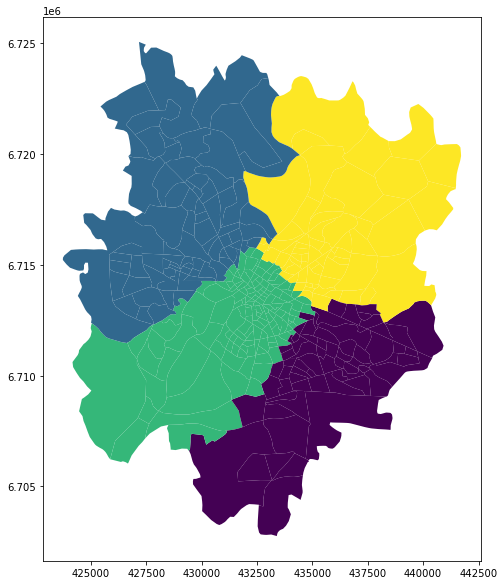

In [25]:
zones.plot('cluster')

In [26]:
zones.head()

,geometry,cluster
zone_id,,
zone_262,"POLYGON ((436077.018 6713850.732, 436038.038 6...",3
zone_121,"POLYGON ((431754.200 6715635.500, 431665.456 6...",1
zone_132,"POLYGON ((428702.038 6712942.714, 428791.695 6...",2
zone_15,"POLYGON ((432268.814 6712951.361, 432460.969 6...",2
zone_67,"POLYGON ((431441.755 6711477.345, 431336.800 6...",2


In [27]:
neighbors.zones_classified_neighborhood??

Signature:
neighbors.zones_classified_neighborhood(
    zones,
    volumes,
    folder,
    macro_col,
    by='origin',
    volume_col='vol',
    **kwargs,
)
Source:   
def zones_classified_neighborhood(
    zones, volumes, folder, macro_col, by='origin', volume_col='vol', **kwargs):
    """
    This function applies the neighboorhood algorithm several times, in order to keep track of the
    information of the macro zone of origin/destination, for all loaded links.
    For each macro zone:
        - the volumes having their origin/destination within this macrozone are identified.
        - the neighboorhood algorithm assigns these volumes on the graph
        - The links are given the color of the macro zone and exported as shpfile
    """
    # Check number of macro zones
    if len(zones[macro_col].unique()) > 12:
        print("{} macro zones, that's is going to be difficult to plot. Please give a color palette to try.")
        return(None)
    
    # sort volumes
    volume_matri

In [21]:
neighbors.zones_classified_neighborhood(
    zones, ods, ipath + r'desire_lines/macro/', 'cluster', volume_col='volume'
)


2


FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 144.12it/s]


3


FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 139.82it/s]


1


FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 136.05it/s]


0


FloatProgress(value=0.0, max=8.0)

neighborhood_dataframe: 100%|██████████| 370/370 [00:02<00:00, 131.00it/s]
0it [00:00, ?it/s]


PermissionError: [WinError 32] Le processus ne peut pas accéder au fichier car ce fichier est utilisé par un autre processus: 'inputs/desire_lines/macro//desire_lines_2.geojson'